## 1. Creating the prerequisites

**Import libraries**

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns

from torchvision import datasets as dts
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.notebook import tqdm
from termcolor import colored, cprint
from scipy.stats import mannwhitneyu
import scipy.stats as ss
import warnings
from IPython.display import clear_output
from bisect import bisect
warnings.filterwarnings('ignore')
print(torch.__version__)
torch_device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch_device)
plt.style.use('bmh')

1.13.0
cpu


**MNIST dataset**

In [2]:
traindt = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
testdt = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

train_loader= torch.utils.data.DataLoader(traindt, batch_size=100, shuffle=True, num_workers=1)

In [3]:
# Split data from labels. Something like unzip.

test_img   = torch.cat([data[0] for data in testdt]).view(-1, 28*28).to(torch_device)
test_label = torch.Tensor([data[1] for data in testdt]).to(torch_device)
test_num   = len(testdt)

train_img   = torch.cat([data[0] for data in traindt]).view(-1, 28*28).to(torch_device)
train_label = torch.Tensor([data[1] for data in traindt]).to(torch_device)
train_num   = len(traindt)

class_num = int(torch.max(train_label).data.cpu().numpy()+1)

print("train num:   ", train_num)
print("train shape: ", train_img.shape)
print("test num:    ", test_num)
print("test shape:  ", test_img.shape)
print("class num:   ", class_num)


train num:    60000
train shape:  torch.Size([60000, 784])
test num:     10000
test shape:   torch.Size([10000, 784])
class num:    10


In [4]:
target_label = 2
bin_train_label = (train_label==target_label).data.cpu().numpy().astype(int)
bin_test_label  = (test_label ==target_label).data.cpu().numpy().astype(int)

### 2. Processing models

**LogReg**

In [5]:
class BinaryLogisticRegression(torch.nn.Module):    
    def __init__(self):
        super(BinaryLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(784, 1)
        
    def forward(self, x):
        return self.linear(x)
    
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)


class CNN_MNIST(nn.Module):
    def __init__(self, out_ch=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(8 * 7 * 7, out_ch)
        )
        
    def forward(self, x):
        return self.layers(x.reshape(-1, 28, 28).unsqueeze(1))

In [6]:
model = CNN_MNIST().to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterions = torch.nn.CrossEntropyLoss().to(torch_device)
n_epochs = 3

In [7]:
for epoch in tqdm(range(n_epochs)):
    for (images, labels) in train_loader:
        b_x = Variable(images.view(-1, 28 * 28)).to(torch_device)
        b_y = Variable(labels).to(torch_device)
        b_y = (b_y==target_label).float()
        output = model(b_x).squeeze()
        loss = criterions(output, b_y)
        optimizer.zero_grad()           
        loss.backward()              
        optimizer.step()

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
train_pred_scores  = model(train_img).squeeze().data.cpu().numpy()
test_pred_scores   = model(test_img).squeeze().data.cpu().numpy()

In [9]:
def empirical_p_values(distribution, query):
    
    dist_len = len(distribution)
    query_len = len(query)
    
    p_values = np.zeros([query_len,])
    
    for i, score in enumerate(query):
        p_values[i] = (dist_len-bisect(distribution, score))/dist_len
        
    return np.sort(p_values)

def calculate_qvalues_from_labels(scores, labels):

    sort_data = torch.sort(scores, descending=True)
    sorted_test_scores = sort_data[0].data.cpu().numpy()
    sorted_test_labels = labels[sort_data[1].data.cpu().numpy()]

    negative = 0
    positive = 0
    fdr = []
    
    for label in sorted_test_labels:
        negative += label == 0
        positive += label == 1
        fdr.append(negative / (negative+positive) )
    
    qvalue = fdr

    for i in range(len(fdr)-1, 0, -1): 
        qvalue[i-1] = min(qvalue[i], qvalue[i-1])
        
    return qvalue

# Procedure to calculate q-values with using p-value, true labels not used.
def calculate_qvalues_from_pvalues(distribution, query, pi_0=0.9):
    p_values = empirical_p_values(np.sort(distribution), query)
    q_values = p_values*len(p_values)*pi_0
    q_values = q_values/np.arange(len(p_values))
    for i in range(len(p_values)-1,0,-1):
        q_values[i-1] = min(q_values[i-1], q_values[i])

    return q_values#, p_values


In [635]:
q_shift, p_shift = calculate_qvalues_from_pvalues(train_score_neg, test_pred_scores_shift_upd, 
                                                  np.mean(test_pred_scores <= 0.))
q_base, p_base = calculate_qvalues_from_pvalues(train_score_neg, test_pred_scores_shift, 
                                         np.mean(test_pred_scores <= 0.))

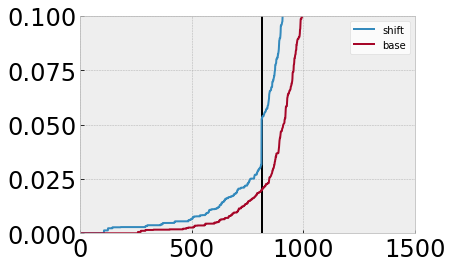

In [640]:
plt.axvline(x=814, color='black')
plt.plot(q_shift, label='shift')
plt.plot(q_base, label='base')
ax = plt.gca()
ax.set(ylim=((0,0.1)), xlim=((0,1500)))
plt.legend()

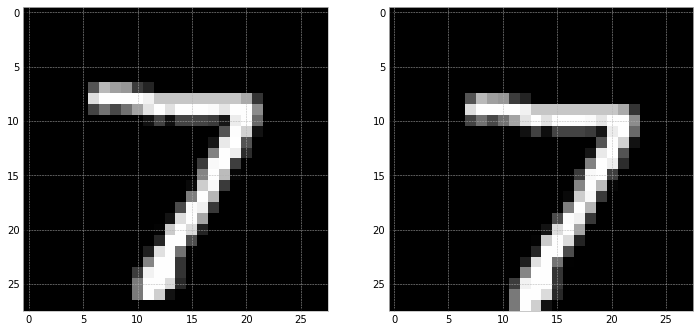

In [10]:
from torchvision.transforms import ToTensor, functional
import torch.nn.functional as F

def pixel_shift(img):
    h, w = img.shape
    down_by_one = functional.crop(img, top=0, left=0, height=h-1, width=w)
    right_by_one = functional.crop(down_by_one, 0, 0, h-1, w-1)
    return F.pad(right_by_one, (1, 0, 1, 0))
    

test_img_shift  = torch.cat([pixel_shift(img.reshape(28, 28)) for img in test_img]).view(-1, 784).to(torch_device)
test_pred_scores_shift = model(test_img_shift)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax[0].imshow(test_img[0].reshape(28, 28).numpy(), cmap='gray')
ax[1].imshow(test_img_shift[0].reshape(28, 28).numpy(), cmap='gray')
plt.show()

In [11]:
np.mean((test_pred_scores_shift[:, 0] > 0).detach().numpy() == bin_test_label)

0.9432

In [11]:
def calculate_fdr(scores, labels):
    sort_data = torch.sort(scores, descending=True)
    sorted_test_scores = sort_data[0].data.cpu().numpy()
    sorted_test_labels = labels[sort_data[1].data.cpu().numpy()]

    negative = 0
    positive = 0
    fdr = []
    
    for label in sorted_test_labels:
        negative += label.item() == 0
        positive += label.item() == 1
        fdr.append(negative / (negative+positive) )
    return np.array(fdr)

from scipy.stats import binom

def hb_p_value(r_hat, n, alpha=0.1):
    bentkus_p_value = np.e * binom.cdf(np.ceil(n * r_hat), n, alpha)
    def h1(y,mu):
        with np.errstate(divide='ignore'): return y * np.log(y/mu) + (1-y) * np.log((1-y)/(1-mu))
        
    hoeffding_p_value = np.exp(-n * h1(min(r_hat, alpha), alpha))
    return min(bentkus_p_value, hoeffding_p_value)

from statsmodels.stats.multitest import multipletests

def bonferroni(p_values,delta):
    rejections, _, _, _ = multipletests(p_values,delta,method='holm',is_sorted=False,returnsorted=False)
    R = np.nonzero(rejections)[0]
    return R 

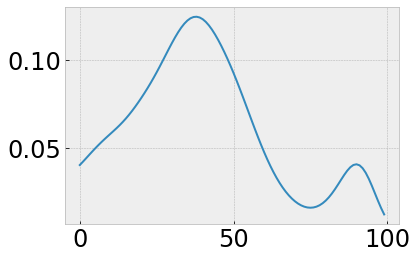

In [35]:
import scipy.stats
kde = scipy.stats.gaussian_kde(test_pred_scores_shift[:, 0].detach().numpy())
data = [i for i in np.linspace(-12, 2, 100)]
y_axis = kde(data)
plt.plot(y_axis)
plt.show()
from scipy.signal import argrelextrema
board = data[argrelextrema(y_axis, np.less)[0][0]]

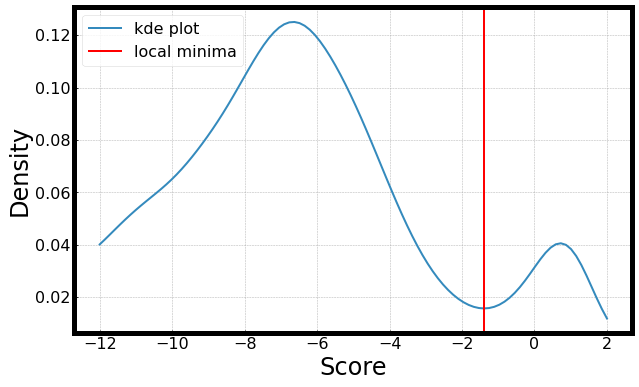

In [48]:
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.facecolor"] = 'white'
fig, ax = plt.subplots(figsize=(10, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)
    ax.spines[axis].set_color("black")
ax.plot(data, y_axis, label='kde plot')
ax.axvline(board, label='local minima', color='red')
ax.set(xlabel='Score', ylabel='Density', facecolor='white')
ax.legend(prop={'size': 16})
plt.show()

In [13]:
train_score_pos = train_pred_scores[bin_train_label == 1.]
train_score_neg = train_pred_scores[bin_train_label == 0.] 
test_score_pos = test_pred_scores[bin_test_label == 1.]
test_score_neg = test_pred_scores[bin_test_label == 0.] 
test_score_pos_shift  = test_pred_scores_shift[test_pred_scores_shift >= board]
test_score_neg_shift  = test_pred_scores_shift[test_pred_scores_shift < board] 

p_values = empirical_p_values(np.sort(train_score_neg), test_score_neg)        
p_value_position = np.arange(len(p_values))/len(p_values)

In [14]:
train_score_pos_sig = nn.Sigmoid()(torch.from_numpy(train_pred_scores[bin_train_label == 1.]
                                                  )).detach().numpy()
train_score_neg_sig = nn.Sigmoid()(torch.from_numpy(train_pred_scores[bin_train_label == 0.] 
                                                  )).detach().numpy()
test_score_pos_sig = nn.Sigmoid()(torch.from_numpy(test_pred_scores[bin_test_label == 1.]
                                                 )).detach().numpy()
test_score_neg_sig = nn.Sigmoid()(torch.from_numpy(test_pred_scores[bin_test_label == 0.] 
                                                 )).detach().numpy()
test_score_pos_shift_sig  = nn.Sigmoid()(test_pred_scores_shift[test_pred_scores_shift >= board])
test_score_neg_shift_sig  = nn.Sigmoid()(test_pred_scores_shift[test_pred_scores_shift < board])
test_pred_scores_shift_sig =  nn.Sigmoid()(test_pred_scores_shift)

p_values = empirical_p_values(np.sort(train_score_neg), test_score_neg)        
p_value_position = np.arange(len(p_values))/len(p_values)

In [14]:
test_score_neg_shift_upd = \
                (test_score_neg_shift - torch.mean(test_score_neg_shift)) /  torch.std(test_score_neg_shift) \
                * np.std(train_score_neg) + np.mean(train_score_neg)

test_score_pos_shift_upd = \
                (test_score_pos_shift - torch.mean(test_score_pos_shift)) + np.mean(train_score_pos) #/  torch.std(test_score_pos_shift) \
                #* np.std(train_score_pos) + np.mean(train_score_pos)

In [40]:
torch.min(test_score_pos_shift)

tensor(-0.4977, grad_fn=<MinBackward1>)

In [16]:
np.mean(train_score_pos),  torch.mean(test_score_pos_shift), torch.mean(test_score_pos_shift_upd)

(4.1374216,
 tensor(2.3613, grad_fn=<MeanBackward0>),
 tensor(4.1374, grad_fn=<MeanBackward0>))

In [17]:
np.var(train_score_pos),  torch.var(test_score_pos_shift), torch.var(test_score_pos_shift_upd)

(5.534721,
 tensor(5.7115, grad_fn=<VarBackward0>),
 tensor(5.5347, grad_fn=<VarBackward0>))

In [15]:
test_pred_scores_shift_upd = torch.concat([test_score_pos_shift_upd, test_score_neg_shift_upd])

In [68]:
test_pred_scores_shift_upd[1027]

tensor(-7.4436, grad_fn=<SelectBackward0>)

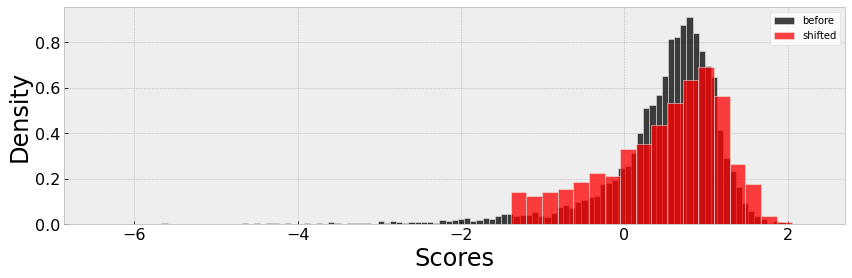

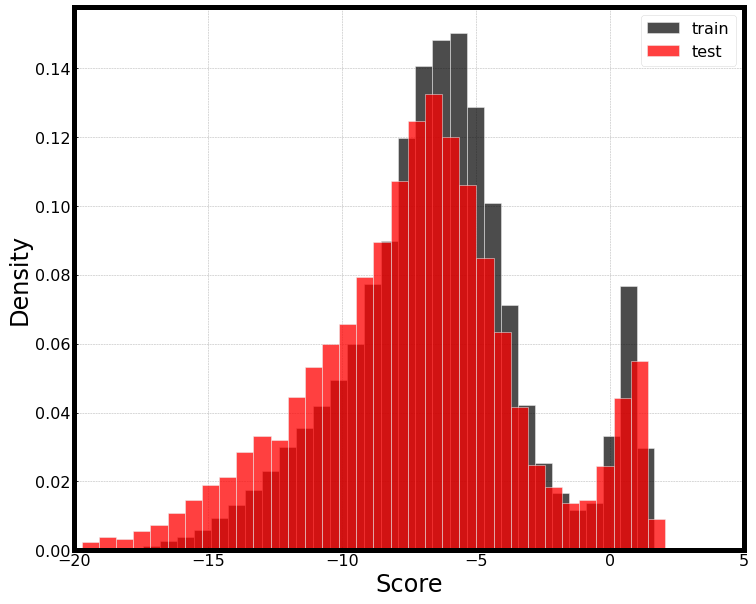

NameError: name 'test_pred_scores_shift_upd_f' is not defined

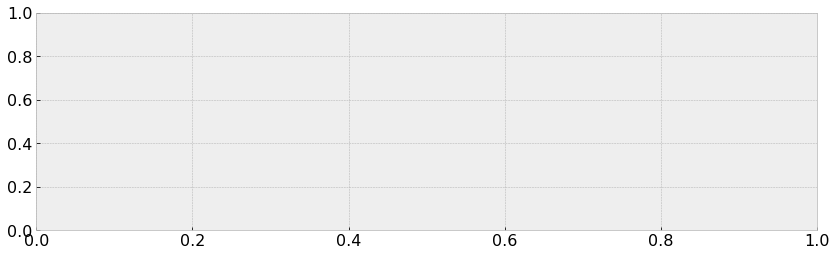

In [110]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.histplot(train_score_pos, color='black', stat='density', label='before')
sns.histplot(test_score_pos_shift.detach().numpy(), color='red', stat='density', label='shifted')
ax.set_xlabel('Scores')
#sns.histplot(test_score_pos_shift_upd.detach().numpy(), color='green', stat='density')
ax.legend()
plt.show()
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.facecolor"] = 'white'
plt.rcParams['axes.axisbelow'] = True
fig, ax = plt.subplots(figsize=(12, 10))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)
    ax.spines[axis].set_color("black")
ax.set(xlabel='Score', ylabel='Density', facecolor='white')
sns.histplot(train_pred_scores, color='black', label='train', bins=40, alpha=0.7, stat='density')
sns.histplot(test_pred_scores_shift[:, 0].detach().numpy(), color='red', label='test', bins=40, stat='density')
#sns.histplot(test_score_neg_shift_upd.detach().numpy(), color='red', stat='density', label='negative test updated')
#sns.histplot(test_score_neg_shift.detach().numpy(), color='red', stat='density')
#ax.axvline(x=test_pred_scores_shift_upd[1027].detach().numpy(), color='orange', label='f(Xi)', lw=7)
ax.legend(prop={'size': 16})
ax.set(xlim=((-20, 5)))
plt.show()
fig, ax = plt.subplots(figsize=(14, 4))
#sns.histplot(train_pred_scores, color='black', stat='density', label='train')
sns.histplot(test_pred_scores_shift_upd_f.detach().numpy(), color='orange', stat='count', alpha=0.5, label='stat_2')
sns.histplot(test_pred_scores_shift[:, 0].detach().numpy(), color='blue', stat='count', label='baseline')
sns.histplot(test_pred_scores_shift_upd.detach().numpy(), color='green', stat='count', label='stat_1')
plt.axvline(x=board)
plt.legend()


In [32]:
np.max(qvalues)

nan

100%|█████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s]


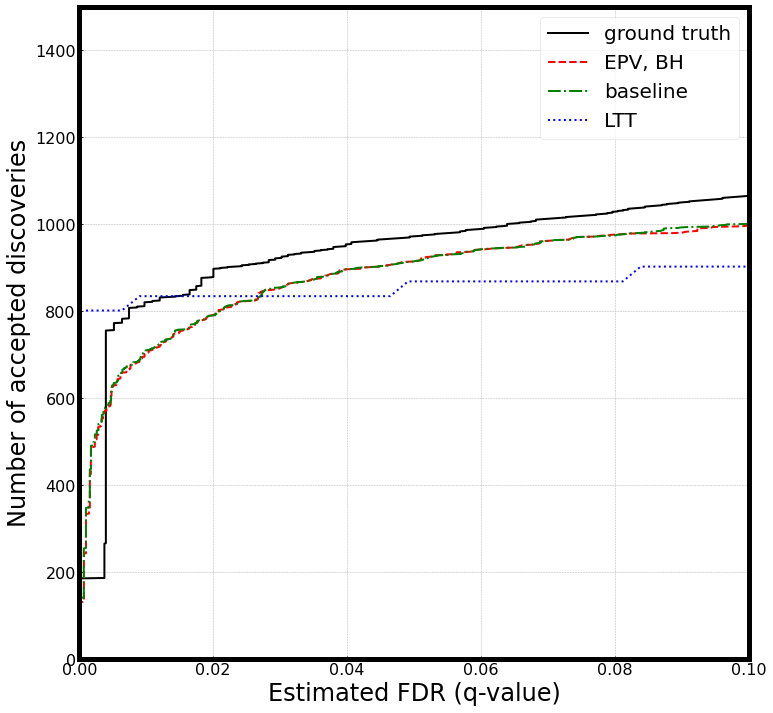

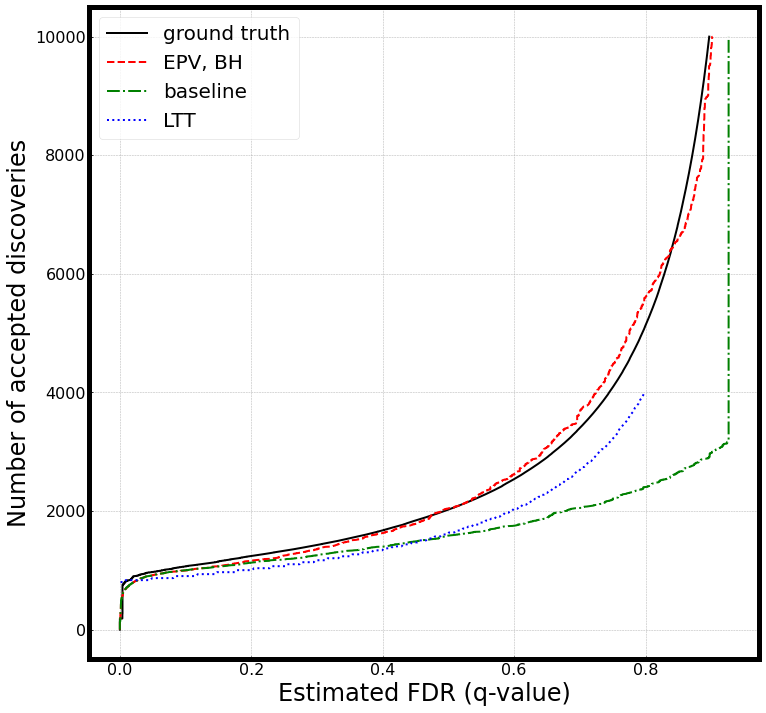

In [111]:
fig1, ax1 = plt.subplots(figsize=(12, 12))
fig2, ax2 = plt.subplots(figsize=(12, 12))
for ax in [ax1, ax2]:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(5)
        ax.spines[axis].set_color("black")
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams["legend.facecolor"] = 'white'

qvalues  = calculate_qvalues_from_labels(test_pred_scores_shift[:, 0], bin_test_label)
ax1.plot(qvalues, np.arange(len(qvalues)), color='black', label='ground truth')
ax2.plot(qvalues, np.arange(len(qvalues)), color='black', label='ground truth')
qvalues = calculate_qvalues_from_pvalues(train_score_neg,#.detach().numpy(), 
                                        test_pred_scores_shift_upd.detach().numpy(), 
                                          np.mean(test_pred_scores_shift.detach().numpy() <= board))
ax1.plot(qvalues, np.arange(len(qvalues)), 'r--', label='EPV, BH', markeredgewidth=10)
ax2.plot(qvalues, np.arange(len(qvalues)), 'r--', label='EPV, BH', markeredgewidth=10)

'''qvalues = calculate_qvalues_from_pvalues(train_score_neg,#.detach().numpy(), 
                                        test_pred_scores_shift_upd_f.detach().numpy(), 
                                          np.mean(test_pred_scores_shift.detach().numpy() <= 0))
ax1.plot(qvalues, np.arange(len(qvalues)), 'y--', label='stat_2', markeredgewidth=10)
ax2.plot(qvalues, np.arange(len(qvalues)), 'y--', label='stat_2', markeredgewidth=10)


qvalues = calculate_qvalues_from_pvalues(train_score_neg_sig,#.detach().numpy(), 
                                        test_pred_scores_shift_sig.detach().numpy(), 
                                         np.mean(test_pred_scores_shift_sig.detach().numpy() <= 0.5))
ax1.plot(qvalues, np.arange(len(qvalues)), 'b-', label='sigmoid', markeredgewidth=10)
ax2.plot(qvalues, np.arange(len(qvalues)), 'b-', label='sigmoid', markeredgewidth=10)

'''
qvalues = calculate_qvalues_from_pvalues(train_score_neg,#.detach().numpy(), 
                                        test_pred_scores_shift.detach().numpy(), 
                                         np.mean(test_pred_scores_shift.detach().numpy() <= 0.))
ax1.plot(qvalues, np.arange(len(qvalues)), 'g-.', label='baseline', markeredgewidth=10)
ax2.plot(qvalues, np.arange(len(qvalues)), 'g-.', label='baseline', markeredgewidth=10)

ax1.set(xlim=((0,0.1)), ylim=((0,1500)))
ax1.set(xlabel='Estimated FDR (q-value)', ylabel='Number of accepted discoveries', facecolor='white')
ax2.set(xlabel='Estimated FDR (q-value)', ylabel='Number of accepted discoveries', facecolor='white')

train_fdrs = calculate_fdr(torch.from_numpy(train_pred_scores), (train_pred_scores > 0.).astype(np.float))
lambdas = np.array(train_pred_scores.shape[0] * torch.linspace(0, 1., 300)).astype(int)[:-1]
r_hats = train_fdrs[lambdas]
plt_data = []
for alpha in tqdm(np.linspace(0.001, 0.8, 300)):
    pvalues = np.array([hb_p_value(r_hat, train_pred_scores.shape[0], alpha=alpha) for r_hat in r_hats])
    chosen = lambdas[bonferroni(pvalues, 0.15)] / bin_train_label.shape[0] * bin_test_label.shape[0]
    idx = int(chosen[-1])
    plt_data.append((idx, alpha))
plt_data = np.array(plt_data)  
ax1.plot(plt_data[:, 1], plt_data[:, 0], 'b:', label='LTT', markeredgewidth=14)
ax2.plot(plt_data[:, 1], plt_data[:, 0], 'b:', label='LTT', markeredgewidth=14)


ax2.legend(prop={'size': 20})
ax1.legend(prop={'size': 20})



fig1.savefig('cnn_shift_test_pred_no_labels_loc.png', dpi=300)
fig2.savefig('cnn_shift_test_pred_no_labels.png', dpi=300)

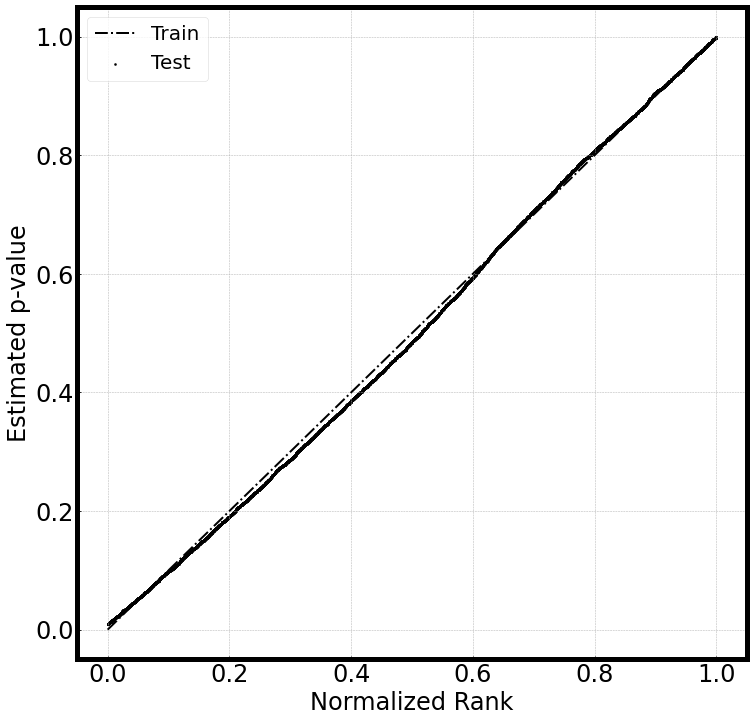

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams["legend.facecolor"] = 'white'

ax.plot([0,1],[0,1], 'k-.', label='Train')  # Plot diagonal

'''p_values = empirical_p_values(np.sort(train_score_neg), test_score_neg_shift)        
p_value_position = np.arange(len(p_values))/len(p_values)
ax.scatter(p_value_position, p_values, color='black', s=4, label='Sigmoid')'''

p_values = empirical_p_values(np.sort(train_score_neg), test_score_neg_shift_upd)        
p_value_position = np.arange(len(p_values))/len(p_values)
ax.scatter(p_value_position, p_values, color='black', s=4, label='Test')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)
    ax.spines[axis].set_color("black")
ax.set(xlabel='Normalized Rank', ylabel='Estimated p-value',title='', facecolor='white')
ax.legend(prop={'size': 20})
plt.show()
fig.savefig('cnn_QQ_shift_binary_no.png', dpi=300)

100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


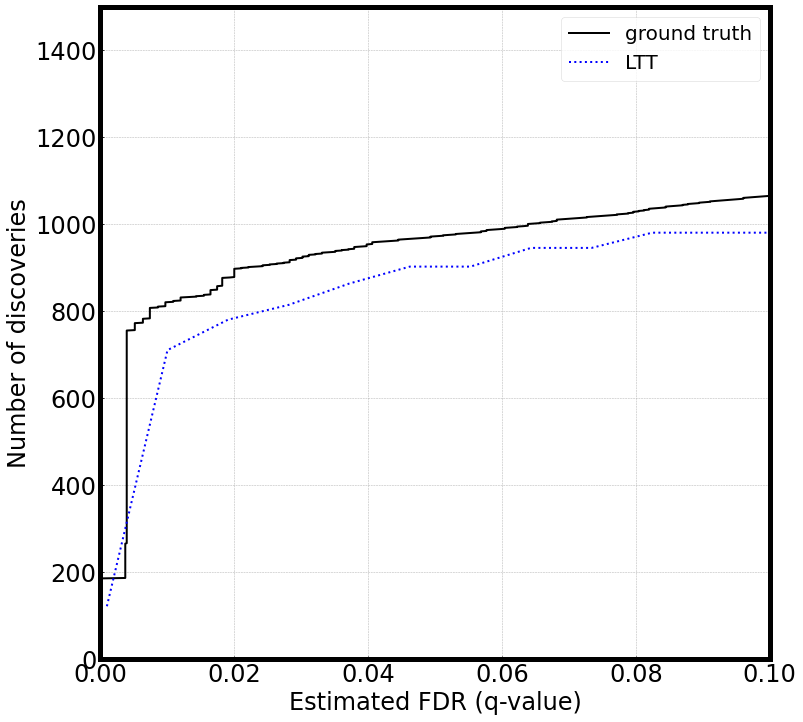

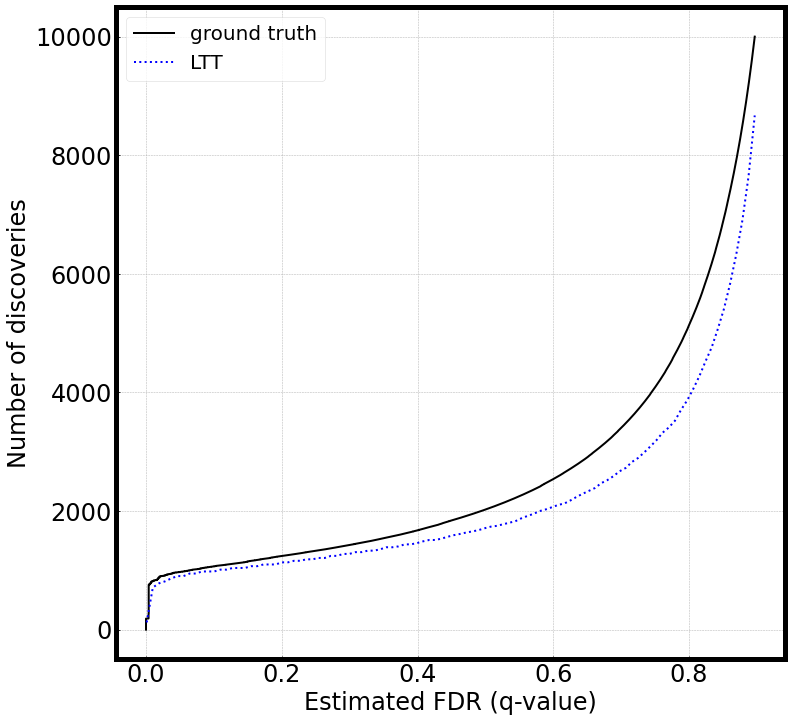

In [34]:
from tqdm import tqdm

#train_score_neg_lab = train_pred_scores[bin_train_label == 0] 
fig1, ax1 = plt.subplots(figsize=(12, 12))
fig2, ax2 = plt.subplots(figsize=(12, 12))
for ax in [ax1, ax2]:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(5)
        ax.spines[axis].set_color("black")
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams["legend.facecolor"] = 'white'
qvalues  = calculate_qvalues_from_labels(test_pred_scores_shift[:, 0], bin_test_label)
ax1.plot(qvalues, np.arange(len(qvalues)), color='black', label='ground truth')
ax2.plot(qvalues, np.arange(len(qvalues)), color='black', label='ground truth')
'''qvalues = calculate_qvalues_from_pvalues(train_score_neg_lab, test_pred_scores_shift, 
                                         np.mean(test_pred_scores_shift.detach().numpy() <= 0.))
ax1.plot(qvalues, np.arange(len(qvalues)), 'k--', label='EPV, BH', markeredgewidth=10)
ax2.plot(qvalues, np.arange(len(qvalues)), 'k--', label='EPV, BH', markeredgewidth=10)'''

ax1.set(xlim=((0,0.1)), ylim=((0,1500)))
ax1.set(xlabel='Estimated FDR (q-value)', ylabel='Number of discoveries', facecolor='white')
ax2.set(xlabel='Estimated FDR (q-value)', ylabel='Number of discoveries', facecolor='white')

train_fdrs = calculate_fdr(torch.from_numpy(train_pred_scores), bin_train_label.astype(np.float))
lambdas = np.array(train_pred_scores.shape[0] * torch.linspace(0, 1., 300)).astype(int)[:-1]
r_hats = train_fdrs[lambdas]
plt_data = []
train_prob_scores = nn.Sigmoid()(torch.from_numpy(train_pred_scores))
test_prob_scores = nn.Sigmoid()(test_pred_scores_shift)
for alpha in tqdm(np.linspace(0.001, np.max(qvalues), 100)):
    pvalues = np.array([hb_p_value(r_hat, train_pred_scores.shape[0], alpha=alpha) for r_hat in r_hats])
    chosen = lambdas[bonferroni(pvalues, 0.15)] / bin_train_label.shape[0] * bin_test_label.shape[0]
    chosen_score = np.sort(train_prob_scores)[::-1][lambdas[bonferroni(pvalues, 0.15)][-1]]
    idx_score = torch.sum(test_prob_scores > chosen_score)
    idx = int(chosen[-1])
    plt_data.append((idx, idx_score, alpha))
plt_data = np.array(plt_data)  
ax1.plot(plt_data[:, 2], plt_data[:, 1], 'b:', label='LTT', markeredgewidth=14)
ax2.plot(plt_data[:, 2], plt_data[:, 1], 'b:', label='LTT', markeredgewidth=14)

ax2.legend(prop={'size': 20})
ax1.legend(prop={'size': 20})

#fig1.savefig('cnn_shift_test_pred_with_labels_loc.png', dpi=300)
#fig2.savefig('cnn_shift_test_pred_with_labels.png', dpi=300)

In [29]:
p_values = empirical_p_values(np.sort(train_score_neg_lab), test_score_neg)        
p_value_position = np.arange(len(p_values))/len(p_values)

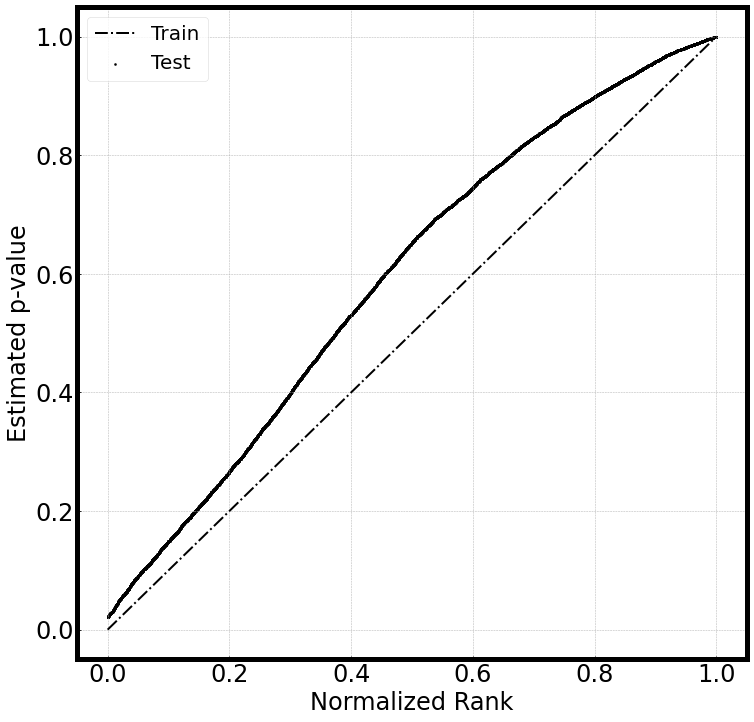

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams["legend.facecolor"] = 'white'


ax.plot([0,1],[0,1], 'k-.', label='Train')  # Plot diagonal
ax.scatter(p_value_position, p_values, color='black', s=4, label='Test')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)
    ax.spines[axis].set_color("black")
ax.set(xlabel='Normalized Rank', ylabel='Estimated p-value',title='', facecolor='white')
ax.legend(prop={'size': 20})
plt.show()
fig.savefig('cnn_QQ_shift_binary_with.png', dpi=300)

In [90]:
np.mean((test_pred_scores_shift > 0) == bin_test_label)

0.0

In [102]:
np.mean((test_pred_scores_shift > 0).detach().numpy()[:, 0] == bin_test_label)

0.9447

In [77]:
from torch_rbf import RBF, basis_func_dict


func = basis_func_dict()['quadratic']
train_score_pos = -nn.Sigmoid()(RBF(1, 1, func)(torch.from_numpy(train_pred_scores[bin_train_label == 1.]
                                                  ).unsqueeze(1))).detach().numpy()
train_score_neg = -nn.Sigmoid()(RBF(1, 1, func)(torch.from_numpy(train_pred_scores[bin_train_label == 0.] 
                                                  ).unsqueeze(1))).detach().numpy()
test_score_pos = nn.Sigmoid()(RBF(1, 1, func)(torch.from_numpy(test_pred_scores[bin_test_label == 1.]
                                                 ).unsqueeze(1))).detach().numpy()
test_score_neg = nn.Sigmoid()(RBF(1, 1, func)(torch.from_numpy(test_pred_scores[bin_test_label == 0.] 
                                                 ).unsqueeze(1))).detach().numpy()
test_score_pos_shift  =  -nn.Sigmoid()(RBF(1, 1, func)(test_pred_scores_shift[bin_test_label == 1]))
test_score_neg_shift  =  -nn.Sigmoid()(RBF(1, 1, func)(test_pred_scores_shift[bin_test_label == 0]))

p_values = empirical_p_values(np.sort(train_score_neg), test_score_neg)        
p_value_position = np.arange(len(p_values))/len(p_values)

IndexError: too many indices for tensor of dimension 1

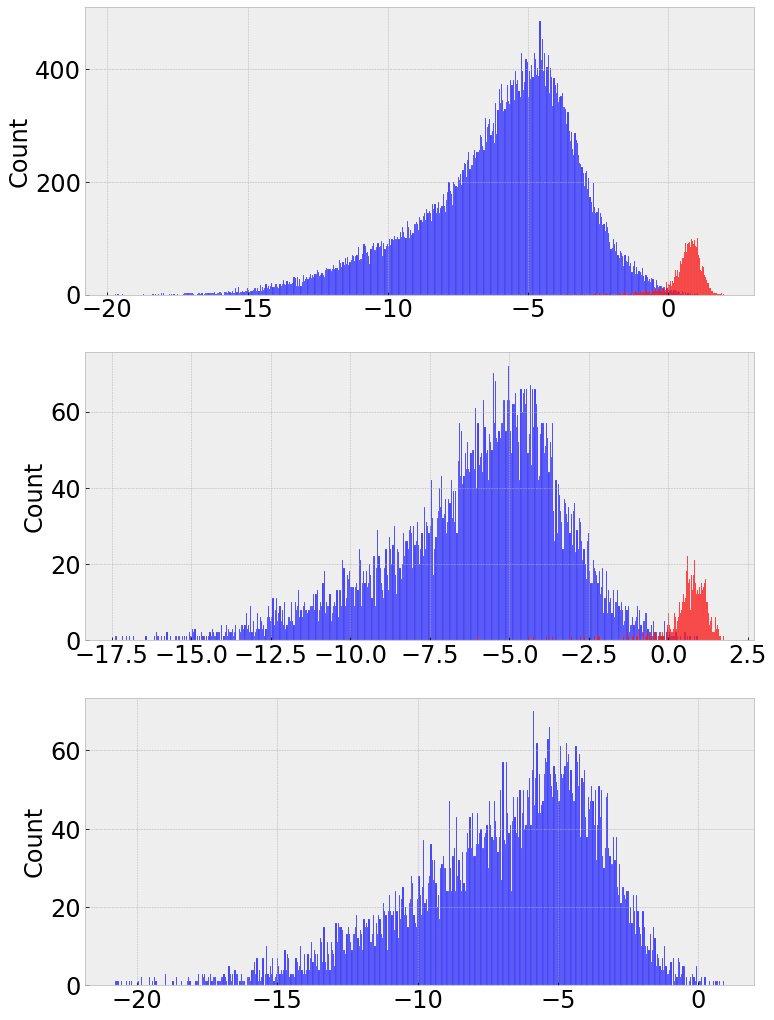

In [88]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
sns.histplot(train_score_neg, color='blue', ax=ax[0], bins=500)
sns.histplot(train_score_pos, color='red', ax=ax[0], bins=500)
sns.histplot(test_score_neg, color='blue', ax=ax[1], bins=500)
sns.histplot(test_score_pos, color='red', ax=ax[1], bins=500)
sns.histplot(test_score_neg_shift[:, 0].detach().numpy(), color='blue', ax=ax[2], bins=500)
sns.histplot(test_score_pos_shift[:, 0].detach().numpy(), color='red', ax=ax[2], bins=500)
ax[0].set(title='Train')
ax[1].set(title='Test')
ax[2].set(title='Test shifted')



for a in ax:
    a.set_yscale('log')


plt.show()